# <a id='toc1_'></a>[Model Evaluation](#toc0_)

This notebook contains the code to evaluate the models on the test set.

**Table of contents**<a id='toc0_'></a>    
- [Model Evaluation](#toc1_)    
- [Import libraries](#toc2_)    
- [Import data](#toc3_)    
- [Prepare data for training](#toc4_)    
  - [Neural network data](#toc4_1_)    
  - [Linear model data](#toc4_2_)    
- [Train Neural Network](#toc5_)    
  - [Constant width](#toc5_1_)    
  - [Pyramid](#toc5_2_)    
- [Train linear models](#toc6_)    
  - [OLS](#toc6_1_)    
  - [LASSO](#toc6_2_)    
  - [Naïve](#toc6_3_)    
- [Summarize the results](#toc7_)    
  - [Variable importance](#toc7_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[Import libraries](#toc0_)

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.compose import ColumnTransformer
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import ConvergenceWarning
from collections import defaultdict

from libs.models import *
from libs.functions import *

plt.rcParams.update({'font.size': 12, 'figure.figsize': (10, 4), 'figure.dpi': 300})

%load_ext autoreload
%autoreload 2

# <a id='toc3_'></a>[Import data](#toc0_)

In [2]:
# read data
df = pd.read_csv('data/data.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

# <a id='toc4_'></a>[Prepare data for training](#toc0_)

In [3]:
# prepare expanding window splits
periods = {
    '21' : '2019-12-31', # 2021 is the test set
    '22' : '2020-12-31', # 2022 is the test set
    '23' : '2021-12-31', # 2023 is the test set
    '24': '2022-12-31' # 2024 is the test set
}

# identify dummy vs. numeric columns
feature_cols = [col for col in df.columns if col not in ['timestamp', 'ticker', 'target']]
nace_cols = [c for c in feature_cols if c.startswith('NACE_')]
dummy_cols = ['divi','divo'] # sin removed
macro_cols = ['discount', 'tms', 'dp', 'ep', 'svar'] # 'bm_macro'

# nummeric cols = cols not in cat and macro cols
numeric_cols = [c for c in feature_cols if c not in dummy_cols and c not in nace_cols and c not in macro_cols]

# feature_cols = numeric_cols + dummy_cols + nace_cols # reorder columns to have numeric first

df_raw = df.copy(deep=True)
df_raw['timestamp'] = pd.to_datetime(df_raw['timestamp'])

# drop data from 2025
df_raw = df_raw[df_raw['timestamp'] < '2025-01-01']
df_raw = df_raw[df_raw['timestamp'] < '2024-12-31']

In [4]:
C = df[numeric_cols].values         # shape = (n_rows, P_c)
X = df[macro_cols].values           # shape = (n_rows, P_x)

# 1) compute all pairwise products with broadcasting:
#    this gives shape (n_rows, P_c, P_x)
K = C[:,:,None] * X[:,None,:]

# 2) reshape to (n_rows, P_c * P_x)
Z = K.reshape(len(df), -1)

# 3) build the column names in the same order
xc_names = [
    f"{c}_x_{m}"
    for c in numeric_cols
    for m in macro_cols
]

# 4) wrap back into a DataFrame
df_xc = pd.DataFrame(Z, columns=xc_names, index=df.index)

feature_cols = numeric_cols + xc_names + dummy_cols + nace_cols
numeric_cols = numeric_cols + xc_names
cat_cols = dummy_cols + nace_cols
df_z = df_raw.merge(df_xc, left_index=True, right_index=True)
# drop macro_cols
df_z = df_z.drop(columns=macro_cols)
# sort columns by feature_cols
df_norm = df_z[['timestamp', 'ticker', 'target'] + feature_cols]

y_values = df_norm['target'].values.astype('float32')


## <a id='toc4_1_'></a>[Neural network data](#toc0_)
Including a validation set

In [5]:
# prepare containers
X_train, X_val, X_test = {}, {}, {}
y_train, y_val, y_test = {}, {}, {}
preprocessors = {}
y_scalers = {}

for y, period in periods.items():
    period = pd.to_datetime(period)

    # split masks
    tr_mask = df_norm['timestamp'] < period
    va_mask = (df_norm['timestamp'] >= period) & \
              (df_norm['timestamp'] - pd.DateOffset(years=1) < period)
    te_mask = (df_norm['timestamp'] - pd.DateOffset(years=1) >= period) & \
              (df_norm['timestamp'] - pd.DateOffset(years=2) < period)

    # extract raw feature DataFrames
    X_tr_df = df_norm.loc[tr_mask, feature_cols].copy()
    X_va_df = df_norm.loc[va_mask, feature_cols].copy()
    X_te_df = df_norm.loc[te_mask, feature_cols].copy()
    y_tr    = y_values[tr_mask]
    y_va    = y_values[va_mask]
    y_te    = y_values[te_mask]

    # compute winsorization bounds on train
    lower = X_tr_df[numeric_cols].quantile(0.01)
    upper = X_tr_df[numeric_cols].quantile(0.99)

    # apply clipping to train, val, test
    X_tr_df[numeric_cols] = X_tr_df[numeric_cols].clip(lower=lower, upper=upper, axis=1)
    X_va_df[numeric_cols] = X_va_df[numeric_cols].clip(lower=lower, upper=upper, axis=1)
    X_te_df[numeric_cols] = X_te_df[numeric_cols].clip(lower=lower, upper=upper, axis=1)

    # now fit scaler on numeric only
    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numeric_cols),
        ('cat', 'passthrough',  cat_cols)
    ])
    preprocessor.fit(X_tr_df)
    preprocessors[y] = preprocessor

    # transform all splits
    X_train[y] = preprocessor.transform(X_tr_df).astype('float32')
    X_val[y]   = preprocessor.transform(X_va_df).astype('float32')
    X_test[y]  = preprocessor.transform(X_te_df).astype('float32')

    # fit standard scaler on y values
    y_scaler = StandardScaler()
    y_scaler.fit(y_tr.reshape(-1, 1))
    y_scalers[y] = y_scaler
    y_tr = y_scaler.transform(y_tr.reshape(-1, 1)).flatten()
    y_va = y_scaler.transform(y_va.reshape(-1, 1)).flatten()
    y_te = y_scaler.transform(y_te.reshape(-1, 1)).flatten()

    # store targets as before
    y_train[y] = y_tr.reshape(-1, 1)
    y_val[y]   = y_va.reshape(-1, 1)
    y_test[y]  = y_te.reshape(-1, 1)


## <a id='toc4_2_'></a>[Linear model data](#toc0_)
Excluding the validation set

In [6]:

Xlin_train, Xlin_test = {}, {}
ylin_train, ylin_test = {}, {}
preprocessors_lin = {}

cat_cols_lin = cat_cols + ['const']
feature_cols_lin = feature_cols + ['const']

for y, period in periods.items():
    period = pd.to_datetime(period)
    tr_mask = df_norm['timestamp']- pd.DateOffset(years=1) < period
    te_mask = (df_norm['timestamp'] - pd.DateOffset(years=1) >= period) & \
              (df_norm['timestamp'] - pd.DateOffset(years=2) < period)

    # extract feature DataFrames
    X_tr_df = df_norm.loc[tr_mask, feature_cols]
    X_te_df = df_norm.loc[te_mask, feature_cols]
    y_tr = y_values[tr_mask]
    y_te = y_values[te_mask]

    # add constant column for linear regression
    X_tr_df['const'] = 1
    X_te_df['const'] = 1

    # compute winsorization bounds on train
    lower = X_tr_df[numeric_cols].quantile(0.01)
    upper = X_tr_df[numeric_cols].quantile(0.99)

    # apply clipping to train, test
    X_tr_df[numeric_cols] = X_tr_df[numeric_cols].clip(lower=lower, upper=upper, axis=1)
    X_te_df[numeric_cols] = X_te_df[numeric_cols].clip(lower=lower, upper=upper, axis=1)

    # fit scaler only on training set
    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numeric_cols),
        ('cat', 'passthrough', cat_cols_lin)
    ])
    preprocessor.fit(X_tr_df)
    preprocessors_lin[y] = preprocessor

    # ttransform splits
    Xlin_train[y] = preprocessor.transform(X_tr_df).astype('float32')
    Xlin_test[y]  = preprocessor.transform(X_te_df).astype('float32')

    # targets
    ylin_train[y] = y_tr
    ylin_test[y]  = y_te

# <a id='toc5_'></a>[Train Neural Network](#toc0_)

## <a id='toc5_1_'></a>[Constant width](#toc0_)

In [7]:
# moving to metal or CUDA GPU if available
device = torch.device(("cuda" if torch.cuda.is_available() 
                       else "mps" if torch.backends.mps.is_available() 
                       else "cpu"))
print("Using device:", device)

# general hyperparameters
hidden_depth = 2 # only hidden, excluding in- and output layers
hidden_width = 64 # int for all being equal width; list for different widths
learning_rate = 5e-5 # 1e-4 # 1e-5
activation_fun = nn.ReLU # nn.ReLU nn.Tanh nn.Sigmoid nn.LeakyReLU

# general critereon and regularization parameters
criterion = nn.MSELoss() # nn.HuberLoss()
lambda_l1 = 1e-4 # 1e-5 # 1e-4 # l1 regularization
lambda_l2 = 1e-3 # 1e-4 # 1e-3 # l2 regularization
dropout = 0.0

# general parmeters
patience = 25
print_freq = 250
epochs = 250
batch_size = 4096

n_runs = 5 # number of runs for each model to average over


Using device: mps


In [8]:
best_models = {}
history   = {}
mlp_pred  = {}

for y, period in periods.items():
    print(f"\n=== Year {y}: running {n_runs} restarts ===")
    all_run_preds = []

    for run in range(n_runs):
        # set random seed for reproducibility (change for each run)
        seed = 42 + run
        np.random.seed(seed)
        torch.manual_seed(seed)
        print(f"Run {run+1}/{n_runs}, seed={seed}")

        # instantiate a fresh model & optimizer
        input_dim = X_train[y].shape[1]
        model = MLPModel(input_dim,
                         depth=hidden_depth,
                         width=hidden_width,
                         dropout=dropout,
                         activation=activation_fun).to(device)
        optimizer = torch.optim.Adam(model.parameters(),
                                      lr=learning_rate)


        # wrap datasets
        train_ds = MLPdataset(X_train[y], y_train[y])
        val_ds   = MLPdataset(X_val[y],   y_val[y])

        # train
        trained_model, hist = train_mlp(train_ds,
                                        val_ds,
                                        model,
                                        criterion,
                                        epochs,
                                        patience,
                                        print_freq,
                                        device,
                                        optimizer=optimizer,
                                        lambda_l1=lambda_l1,
                                        lambda_l2=lambda_l2,
                                        batch_size=batch_size,
                                        shuffle_train=True,
                                        shuffle_val=False,
                                        save_path=f'models/mlp_y{y}_l1{lambda_l1}_l2{lambda_l2}_drop{dropout}_lr{learning_rate}_w{hidden_width}_d{hidden_depth}_run{run+1}.pth'
                                        )

        # predict on test set
        preds = predict_mlp(trained_model,
                            X_test[y],
                            y_test=y_test[y],
                            scaler= y_scalers[y],
                            batch_size=batch_size,
                            device=device)
        all_run_preds.append(preds)

        # optionally store the last run’s model & history
        best_models[(y, run)] = trained_model
        history[(y, run)]     = hist

    # stack (n_runs, n_samples) average over axis=0
    all_run_preds = np.stack(all_run_preds, axis=0)
    mlp_pred[y]   = np.mean(all_run_preds, axis=0)

    print(f"Averaged predictions for year {y} computed.")


=== Year 21: running 5 restarts ===
Run 1/5, seed=42
Early stopping at epoch 72
Best val loss: 1.13764E+00
Model saved to models/mlp_y21_l10.0001_l20.001_drop0.0_lr5e-05_w64_d2_run1.pth
Run 2/5, seed=43
Early stopping at epoch 26
Best val loss: 1.13273E+00
Model saved to models/mlp_y21_l10.0001_l20.001_drop0.0_lr5e-05_w64_d2_run2.pth
Run 3/5, seed=44
Early stopping at epoch 223
Best val loss: 1.12180E+00
Model saved to models/mlp_y21_l10.0001_l20.001_drop0.0_lr5e-05_w64_d2_run3.pth
Run 4/5, seed=45
Early stopping at epoch 26
Best val loss: 1.13586E+00
Model saved to models/mlp_y21_l10.0001_l20.001_drop0.0_lr5e-05_w64_d2_run4.pth
Run 5/5, seed=46
Early stopping at epoch 66
Best val loss: 1.13169E+00
Model saved to models/mlp_y21_l10.0001_l20.001_drop0.0_lr5e-05_w64_d2_run5.pth
Averaged predictions for year 21 computed.

=== Year 22: running 5 restarts ===
Run 1/5, seed=42
Early stopping at epoch 62
Best val loss: 7.01680E-01
Model saved to models/mlp_y22_l10.0001_l20.001_drop0.0_lr5e-0

## <a id='toc5_2_'></a>[Pyramid](#toc0_)

In [9]:
# training model with most data on multiple parameters
hidden_depth_pyr = None
hidden_width_pyr = [32, 16, 8]

In [10]:
best_models_pyr = {}
history_pyr   = {}
mlp_pred_pyr  = {}

for y, period in periods.items():
    print(f"\n=== Year {y}: running {n_runs} restarts ===")
    all_run_preds = []

    for run in range(n_runs):
        # set random seed for reproducibility (change for each run)
        seed = 42 + run
        np.random.seed(seed)
        torch.manual_seed(seed)
        print(f"Run {run+1}/{n_runs}, seed={seed}")

        # instantiate a fresh model & optimizer
        input_dim = X_train[y].shape[1]
        model = MLPModel(input_dim,
                         depth=len(hidden_width_pyr),
                         width=hidden_width_pyr,
                         dropout=dropout,
                         activation=activation_fun).to(device)
        optimizer = torch.optim.Adam(model.parameters(),
                                      lr=learning_rate)


        # wrap datasets
        train_ds = MLPdataset(X_train[y], y_train[y])
        val_ds   = MLPdataset(X_val[y],   y_val[y])

        # train
        trained_model, hist = train_mlp(train_ds,
                                        val_ds,
                                        model,
                                        criterion,
                                        epochs,
                                        patience,
                                        print_freq,
                                        device,
                                        optimizer=optimizer,
                                        lambda_l1=lambda_l1,
                                        lambda_l2=lambda_l2,
                                        batch_size=batch_size,
                                        shuffle_train=True,
                                        shuffle_val=False,
                                        save_path=f'models/mlp_y{y}_l1{lambda_l1}_l2{lambda_l2}_drop{dropout}_lr{learning_rate}_w{hidden_width_pyr}_d{hidden_depth_pyr}_run{run+1}.pth'
                                        )

        # predict on test set
        preds = predict_mlp(trained_model,
                            X_test[y],
                            y_test=y_test[y],
                            scaler= y_scalers[y], # preprocessors[y] if hasattr(preprocessors[y], 'inverse_transform') else None,
                            batch_size=batch_size,
                            device=device)
        all_run_preds.append(preds)

        # optionally store the last run’s model & history
        best_models_pyr[(y, run)] = trained_model
        history_pyr[(y, run)]     = hist

    # stack (n_runs, n_samples) average over axis=0
    all_run_preds = np.stack(all_run_preds, axis=0)
    mlp_pred_pyr[y] = np.mean(all_run_preds, axis=0)

    print(f"Averaged predictions for year {y} computed.")


=== Year 21: running 5 restarts ===
Run 1/5, seed=42
Early stopping at epoch 80
Best val loss: 1.12889E+00
Model saved to models/mlp_y21_l10.0001_l20.001_drop0.0_lr5e-05_w64_d2_run1.pth
Run 2/5, seed=43
Early stopping at epoch 85
Best val loss: 1.13973E+00
Model saved to models/mlp_y21_l10.0001_l20.001_drop0.0_lr5e-05_w64_d2_run2.pth
Run 3/5, seed=44
Early stopping at epoch 159
Best val loss: 1.14440E+00
Model saved to models/mlp_y21_l10.0001_l20.001_drop0.0_lr5e-05_w64_d2_run3.pth
Run 4/5, seed=45
Epoch 250/250  - Train Loss: 9.56915E-01  - Val Loss: 1.13825E+00
Best val loss: 1.13782E+00
Model saved to models/mlp_y21_l10.0001_l20.001_drop0.0_lr5e-05_w64_d2_run4.pth
Run 5/5, seed=46
Early stopping at epoch 101
Best val loss: 1.12726E+00
Model saved to models/mlp_y21_l10.0001_l20.001_drop0.0_lr5e-05_w64_d2_run5.pth
Averaged predictions for year 21 computed.

=== Year 22: running 5 restarts ===
Run 1/5, seed=42
Early stopping at epoch 72
Best val loss: 7.09817E-01
Model saved to models

# <a id='toc6_'></a>[Train linear models](#toc0_)

## <a id='toc6_1_'></a>[OLS](#toc0_)

In [11]:
# linear model
# estimate the parameters
ols_est = {}
ols_pred = {}
ols_coefs = {}


for y in periods.keys():
    print(f"Estimating OLS for {y}...")
    x_tr = Xlin_train[y]
    y_tr = ylin_train[y]
    x_te = Xlin_test[y]
    y_te = ylin_test[y]


    # estimate the parameters
    ols_est[y] = estimate(y_tr, x_tr)
    # ols_pred_train[y] = ols_est[y]['b_hat'] @ x_tr.T
    ols_pred[y] = ols_est[y]['b_hat'] @ x_te.T
    ols_coefs[y] = ols_est[y]['b_hat']

Estimating OLS for 21...
Estimating OLS for 22...


/Users/johan/Documents/04 Uni/10 Thesis/git/MastersThesis/libs/functions.py:197: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(np.diag(cov)).reshape(-1, 1)


Estimating OLS for 23...
Estimating OLS for 24...


In [12]:
ols_coefs_df = pd.DataFrame(ols_coefs, index=feature_cols_lin)

## <a id='toc6_2_'></a>[LASSO](#toc0_)

In [13]:
# linear model
# create a grid using numpy.geomspace
penalty_grid = np.geomspace(1e-7, 100, num = 1000)
lasso_est = {}
# lasso_pred_train = {}
lasso_pred = {}
lasso_coefs = {}


with warnings.catch_warnings():
    warnings.simplefilter("ignore", ConvergenceWarning)
    for y in periods.keys():
        print(f"Estimating LASSO for {y}...")
        x_tr = Xlin_train[y]
        y_tr = ylin_train[y]
        x_te = Xlin_test[y]
        y_te = ylin_test[y]

        # estimate the model using LassoCV
        fit_CV = LassoCV(cv=5, alphas=penalty_grid, max_iter=1000, eps=1e-3, n_jobs=-1).fit(x_tr,y_tr)
        # lasso_pred_train[y] = fit_CV.predict(x_tr)
        lasso_pred[y] = fit_CV.predict(x_te)

        # store the coefficients
        coef = fit_CV.coef_
        lasso_coefs[y] = coef


Estimating LASSO for 21...
Estimating LASSO for 22...
Estimating LASSO for 23...
Estimating LASSO for 24...


In [14]:
lasso_coefs_df = pd.DataFrame(lasso_coefs, index=feature_cols_lin)

## <a id='toc6_3_'></a>[Naïve](#toc0_)

In [15]:
naive_pred = {}

for y in periods.keys():
    # naive prediction is the mean of the training set
    pred = np.mean(ylin_train[y])
    naive_pred[y] = np.full_like(ylin_test[y], pred, dtype=np.float32)

# <a id='toc7_'></a>[Summarize the results](#toc0_)

In [21]:
pred_dfs = []

for y, period in periods.items():
    # rebuild masks
    te_mask = ((df_norm['timestamp'] - pd.DateOffset(years=1) >= period) &
               (df_norm['timestamp'] - pd.DateOffset(years=2) <  period))
    X_te_df = df_norm.loc[te_mask, feature_cols]
    idx = X_te_df.index


    pred_dfs.append(pd.DataFrame({
        'period':    y,
        'timestamp': df_norm.loc[idx, 'timestamp'],
        'ticker':    df_norm.loc[idx, 'ticker'],
        'y_true':    df_norm.loc[idx, 'target'].values.astype('float32'),
        # 'discount':  df.loc[idx, 'discount'].values.astype('float32'),
        'Naïve':  naive_pred[y],
        'OLS':    ols_pred[y].flatten(),
        'LASSO':  lasso_pred[y],
        'MLP':    mlp_pred[y],
        'MLP-Pyr': mlp_pred_pyr[y],
    }, index=idx))

all_preds = pd.concat(pred_dfs).sort_index()

# save predictions
all_preds.to_csv('data/predictions.csv', index=True)

In [22]:
all_preds = pd.read_csv('data/predictions.csv', index_col=0, parse_dates=['timestamp'])
all_preds['period'] = all_preds['period'].astype('string')

metrics_full = {}
results_full = {}
methods = ['Naïve',
           'OLS', 
           'LASSO', 
           'MLP',
           'MLP-Pyr',
           ]
for method in methods:
    for y, period in periods.items():
        y_true = all_preds.loc[all_preds['period'] == y, 'y_true']
        y_pred = all_preds.loc[all_preds['period'] == y, method]
        key = f'{method}{y}'
        results_full[key] = {
            'RMSE': rmse_fun(y_pred, y_true),
            'MAE': mae_fun(y_pred, y_true),
            # 'MADL': madl_fun(y_pred, y_true),
            'AMADL': amadl_fun(y_pred, y_true, delta=0.5)
        }
    key = f'{method}Total'
    results_full[key] = {
        'RMSE': rmse_fun(all_preds[method], all_preds['y_true']),
        'MAE': mae_fun(all_preds[method], all_preds['y_true']),
        # 'MADL': madl_fun(all_preds[method], all_preds['y_true']),
        'AMADL' : amadl_fun(all_preds[method], all_preds['y_true'], delta=0.5)
    }
    
for y in list(periods.keys()) + ['Total']:
    if y != 'Total':
        name = '20' + y
    else:
        name = y
    for metric in ['RMSE',
                   'MAE',
                #    'MADL',
                   'AMADL']:
        key = f'*{metric}*{name}'
        vals = [
            results_full[f'Naïve{y}'][metric],
            results_full[f'OLS{y}'][metric],
            results_full[f'LASSO{y}'][metric],
            results_full[f'MLP{y}'][metric],
            results_full[f'MLP-Pyr{y}'][metric],
        ]
        metrics_full[key] = vals

tab_full = latex_table_grouped(methods,metrics_full)

with open('tabs/prediction_results.tex', 'w') as f:
    f.write(tab_full)
print(tab_full)


\begin{tabular}{clccccc}
\hline\hline \\ [-1.8ex]
 &  & Naïve & OLS & LASSO & MLP & MLP-Pyr \\ 
 \hline 
\multirow[c]{5}{*}{\rotatebox{90}{RMSE}} 
& 2021 & 0.10729 & 0.11147 & 0.10598 & 0.10619 & 0.10609 \\ 
 & 2022 & 0.12309 & 0.12599 & 0.12419 & 0.12432 & 0.12443 \\ 
 & 2023 & 0.10608 & 0.11413 & 0.10856 & 0.10608 & 0.10552 \\ 
 & 2024 & 0.10975 & 0.11445 & 0.11169 & 0.10949 & 0.10948 \\ 
 & Total & 0.11177 & 0.11664 & 0.11281 & 0.11179 & 0.11166 \\ 
\hline\multirow[c]{5}{*}{\rotatebox{90}{MAE}} 
& 2021 & 0.06921 & 0.07593 & 0.06953 & 0.06903 & 0.06882 \\ 
 & 2022 & 0.08553 & 0.08749 & 0.08727 & 0.08722 & 0.08747 \\ 
 & 2023 & 0.06752 & 0.07352 & 0.06862 & 0.06718 & 0.06636 \\ 
 & 2024 & 0.06864 & 0.07467 & 0.07103 & 0.06856 & 0.06843 \\ 
 & Total & 0.07277 & 0.07794 & 0.07414 & 0.07304 & 0.07282 \\ 
\hline\multirow[c]{5}{*}{\rotatebox{90}{AMADL}} 
& 2021 & -0.00444 & 0.00084 & -0.00484 & -0.00481 & -0.00452 \\ 
 & 2022 & 0.01058 & 0.01002 & 0.01000 & 0.01100 & 0.00980 \\ 
 & 2023 & 

## <a id='toc7_1_'></a>[Variable importance](#toc0_)

In [23]:
period_order   = list(periods.keys())             # ['21','22','23','24']
run_order      = list(range(n_runs))              # [0,1,2]

imp_by_model_year = defaultdict(list)

# ols and lasso
for y in period_order:
    X_eval, y_eval = Xlin_test[y], ylin_test[y].flatten()

    beta_ols    = ols_coefs_df[y].loc[feature_cols_lin].values
    beta_lasso  = lasso_coefs_df[y].loc[feature_cols_lin].values 

    imp_by_model_year['OLS'].append(
        importance_lin(beta_ols, X_eval, y_eval, const='const', 
                       feature=feature_cols_lin)
    )
    imp_by_model_year['LASSO'].append(
        importance_lin(beta_lasso, X_eval, y_eval, const='const', 
                       feature=feature_cols_lin)
    )

# constant width mlp
for y in period_order:
    X_eval, y_eval = X_test[y], y_test[y].flatten()

    # mean across runs first
    imp_runs = []
    for r in run_order:
        model = best_models[(y, r)]
        imp_runs.append(importance_nn(model, X_eval, y_eval, device))
    imp_by_model_year['MLP'].append( np.mean(imp_runs, axis=0) )

# pyramid model
for y in period_order:
    X_eval, y_eval = X_test[y], y_test[y].flatten()

    imp_runs = []
    for r in run_order:
        model = best_models_pyr[(y, r)]
        imp_runs.append(importance_nn(model, X_eval, y_eval, device))
    imp_by_model_year['MLP-Pyr'].append( np.mean(imp_runs, axis=0) )

In [33]:
imp_by_model = {
    m : np.mean(vectors, axis=0)           # arithmetic mean over years
    for m, vectors in imp_by_model_year.items()
}

# build a single DataFrame  (rows = features, cols = models)
imp_df = pd.DataFrame(
    { m : vec for m, vec in imp_by_model.items() },
    index = feature_cols
)

base_names = pd.Series(imp_df.index).map(group_label).values
imp_df_agg = (
    imp_df
      .assign(base = base_names)
      .groupby('base', sort=False)
      .sum()
)

# optional: order rows by overall importance
imp_df_agg = imp_df_agg.loc[
    imp_df_agg[['LASSO','MLP']].mean(axis=1).sort_values(ascending=False).index
]

# sort by ranking
imp_df_agg = imp_df_agg.loc[imp_df_agg[['LASSO','MLP']].rank(axis=0, method='max', ascending=False).mean(axis=1).sort_values(ascending=True).index]


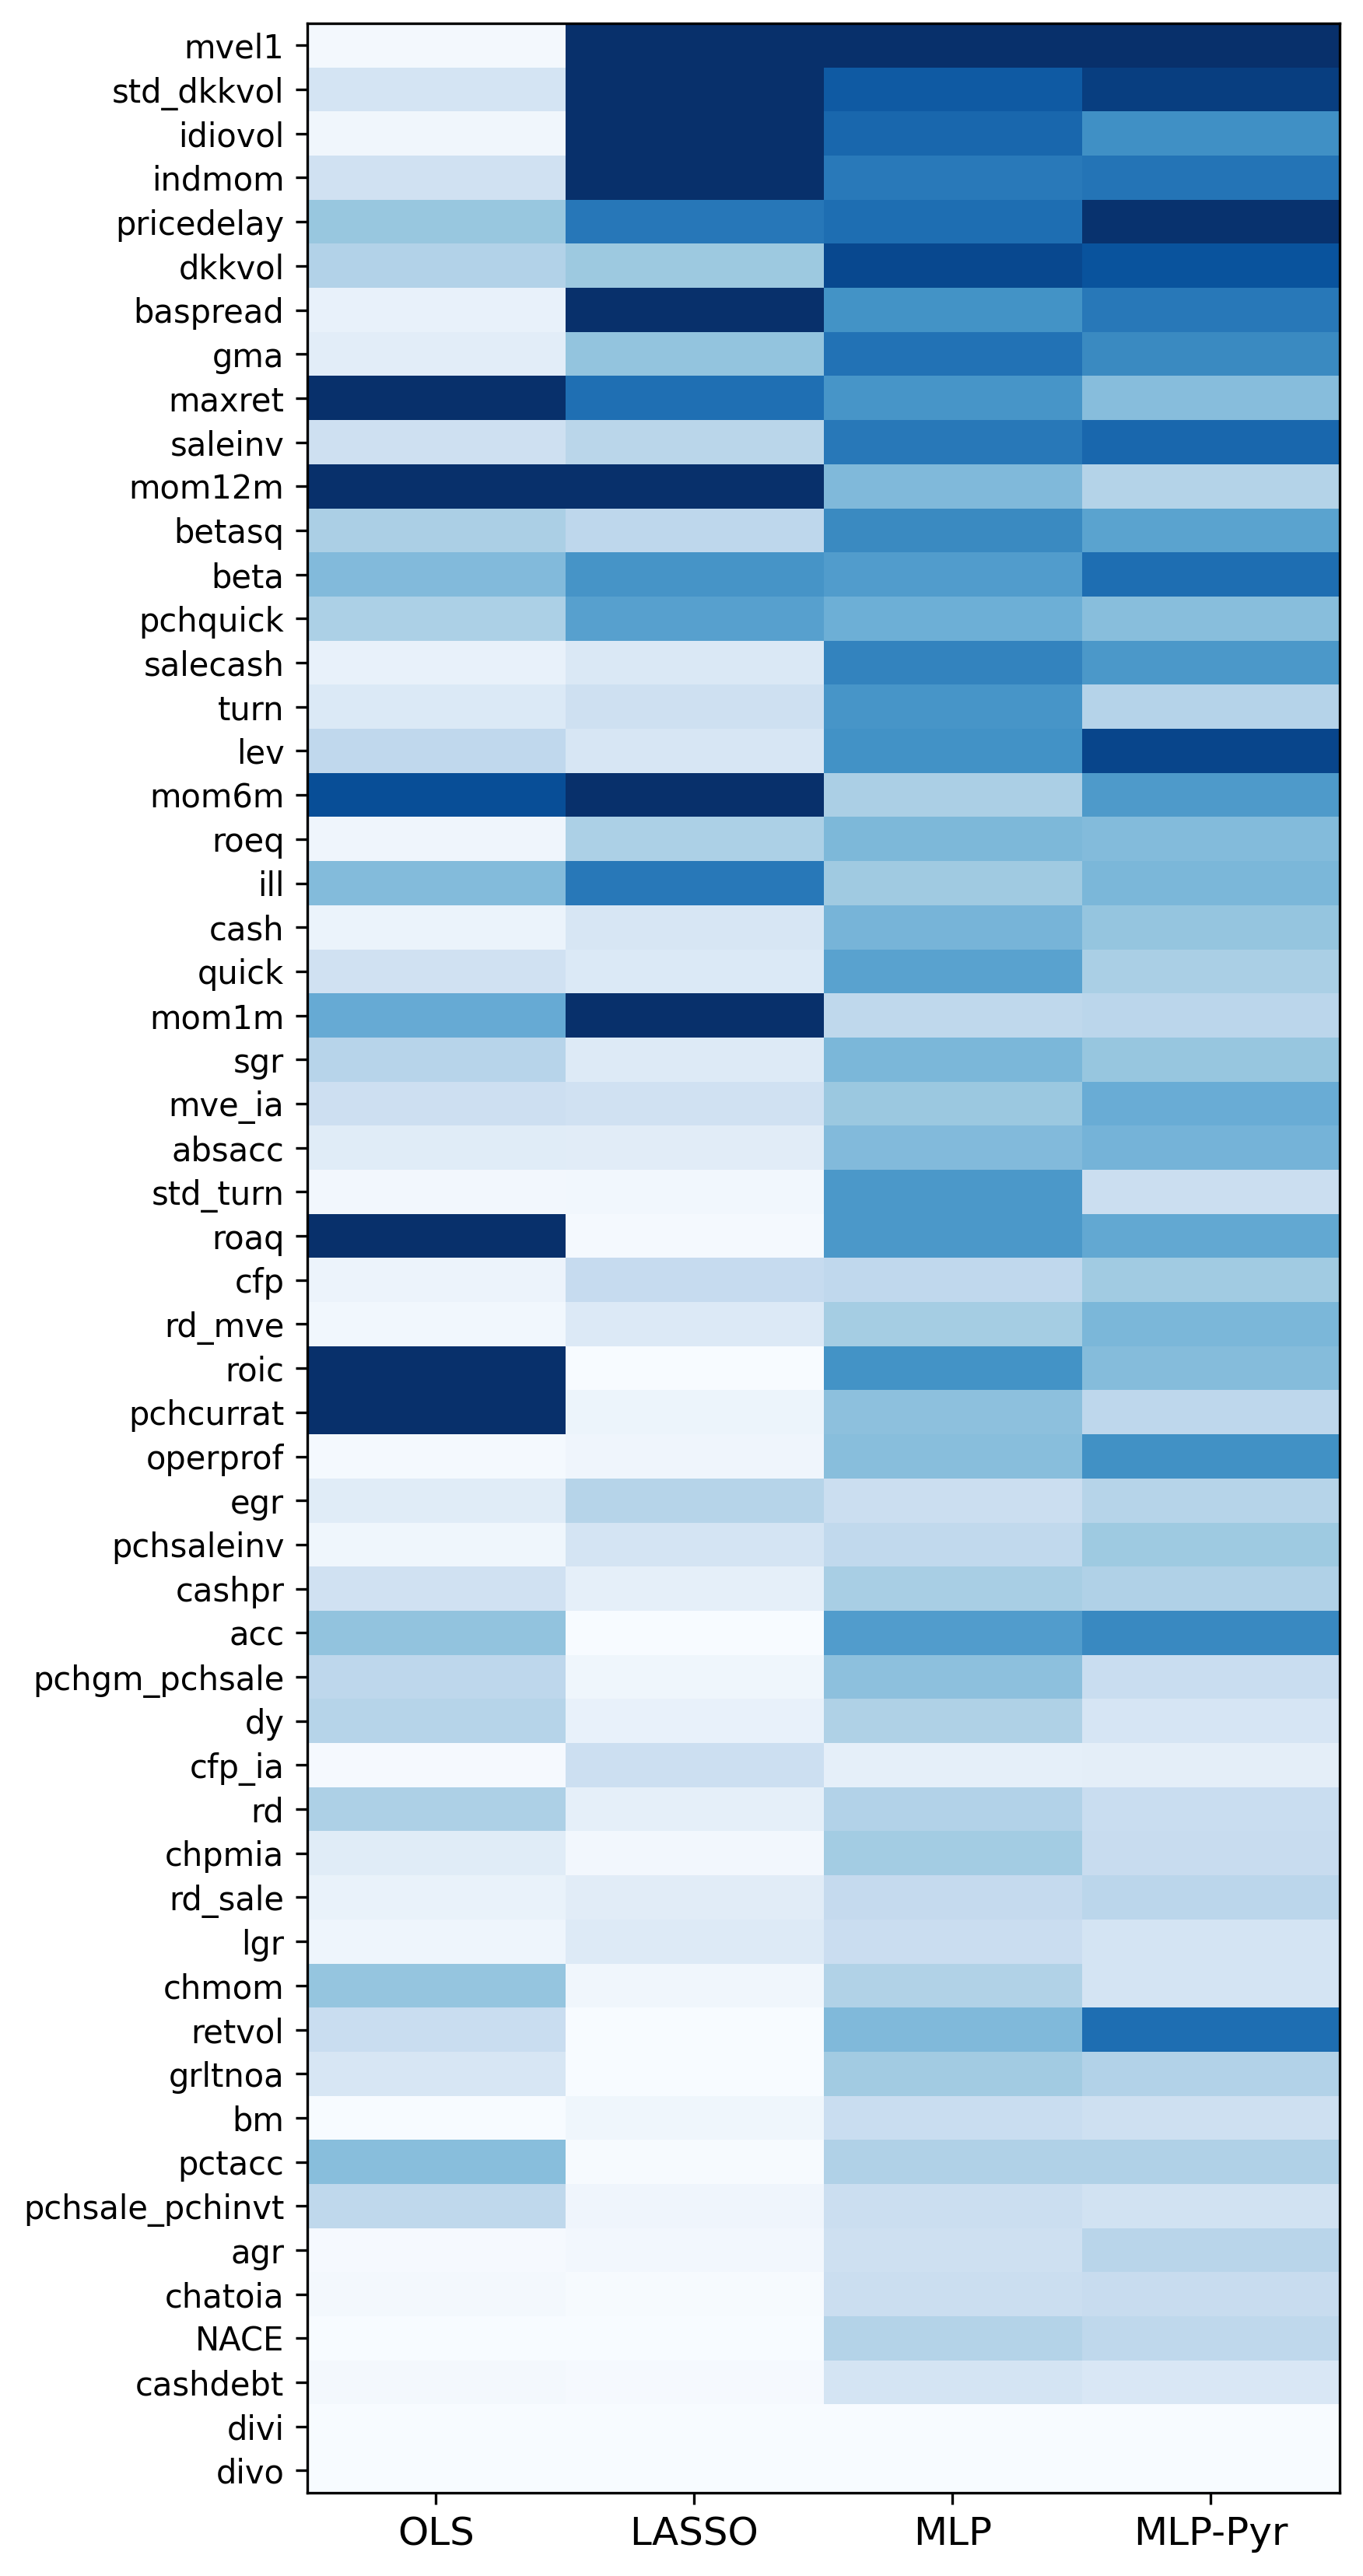

In [34]:
fig, ax = plt.subplots(figsize=(1.5*len(imp_df_agg.columns),
                                0.2*len(imp_df_agg)))

im = ax.imshow(imp_df_agg.values, aspect='auto', cmap='Blues', vmin=0, vmax=.04)
ax.set_xticks(np.arange(len(imp_df_agg.columns)))
ax.set_xticklabels(imp_df_agg.columns, ha='center')
ax.set_yticks(np.arange(len(imp_df_agg.index)))
ax.set_yticklabels(imp_df_agg.index, fontsize=10)

# cbar = fig.colorbar(im, ax=ax, fraction=0.02, pad=0.02)
# cbar.ax.set_ylabel("Normalised $\Delta$MSE",
#                    rotation=-90, va='bottom')

fig.tight_layout()
plt.savefig('figs/variable_importance.png', bbox_inches='tight')
plt.show()
plt.close(fig)

In [26]:
# prepare the (year,run) lists
years    = ['21','22','23','24']
runs     = list(range(n_runs))

mlp_runs     = [(y,r) for y in years for r in runs]
pyr_runs     = [(y,r) for y in years for r in runs]

# ensemble curve for any PyTorch dict
def ensemble_pytorch_curve(model_dict, 
                                    j,            # feature-index
                                    grid,         # array of std-scaled X values
                                    device):
    P     = len(feature_cols)
    G     = len(grid)
    Xg    = np.zeros((G,P), dtype=np.float32)
    Xg[:,j] = grid
    Xt    = torch.tensor(Xg, dtype=torch.float32, device=device)

    all_curves = []
    for y,r in (mlp_runs if model_dict is best_models else pyr_runs):
        m = model_dict[(y,r)]
        m.eval()
        with torch.no_grad():
            zhat = m(Xt).cpu().numpy().flatten()
            z0   = m(torch.zeros((1,P),dtype=torch.float32,device=device)).item()

        # invert to raw % returns
        raw   = y_scalers[y].inverse_transform(zhat.reshape(-1,1)).flatten()*100
        base0 = y_scalers[y].inverse_transform([[z0]]).flatten()[0]*100

        all_curves.append(raw - base0)

    return np.stack(all_curves,axis=0).mean(axis=0)

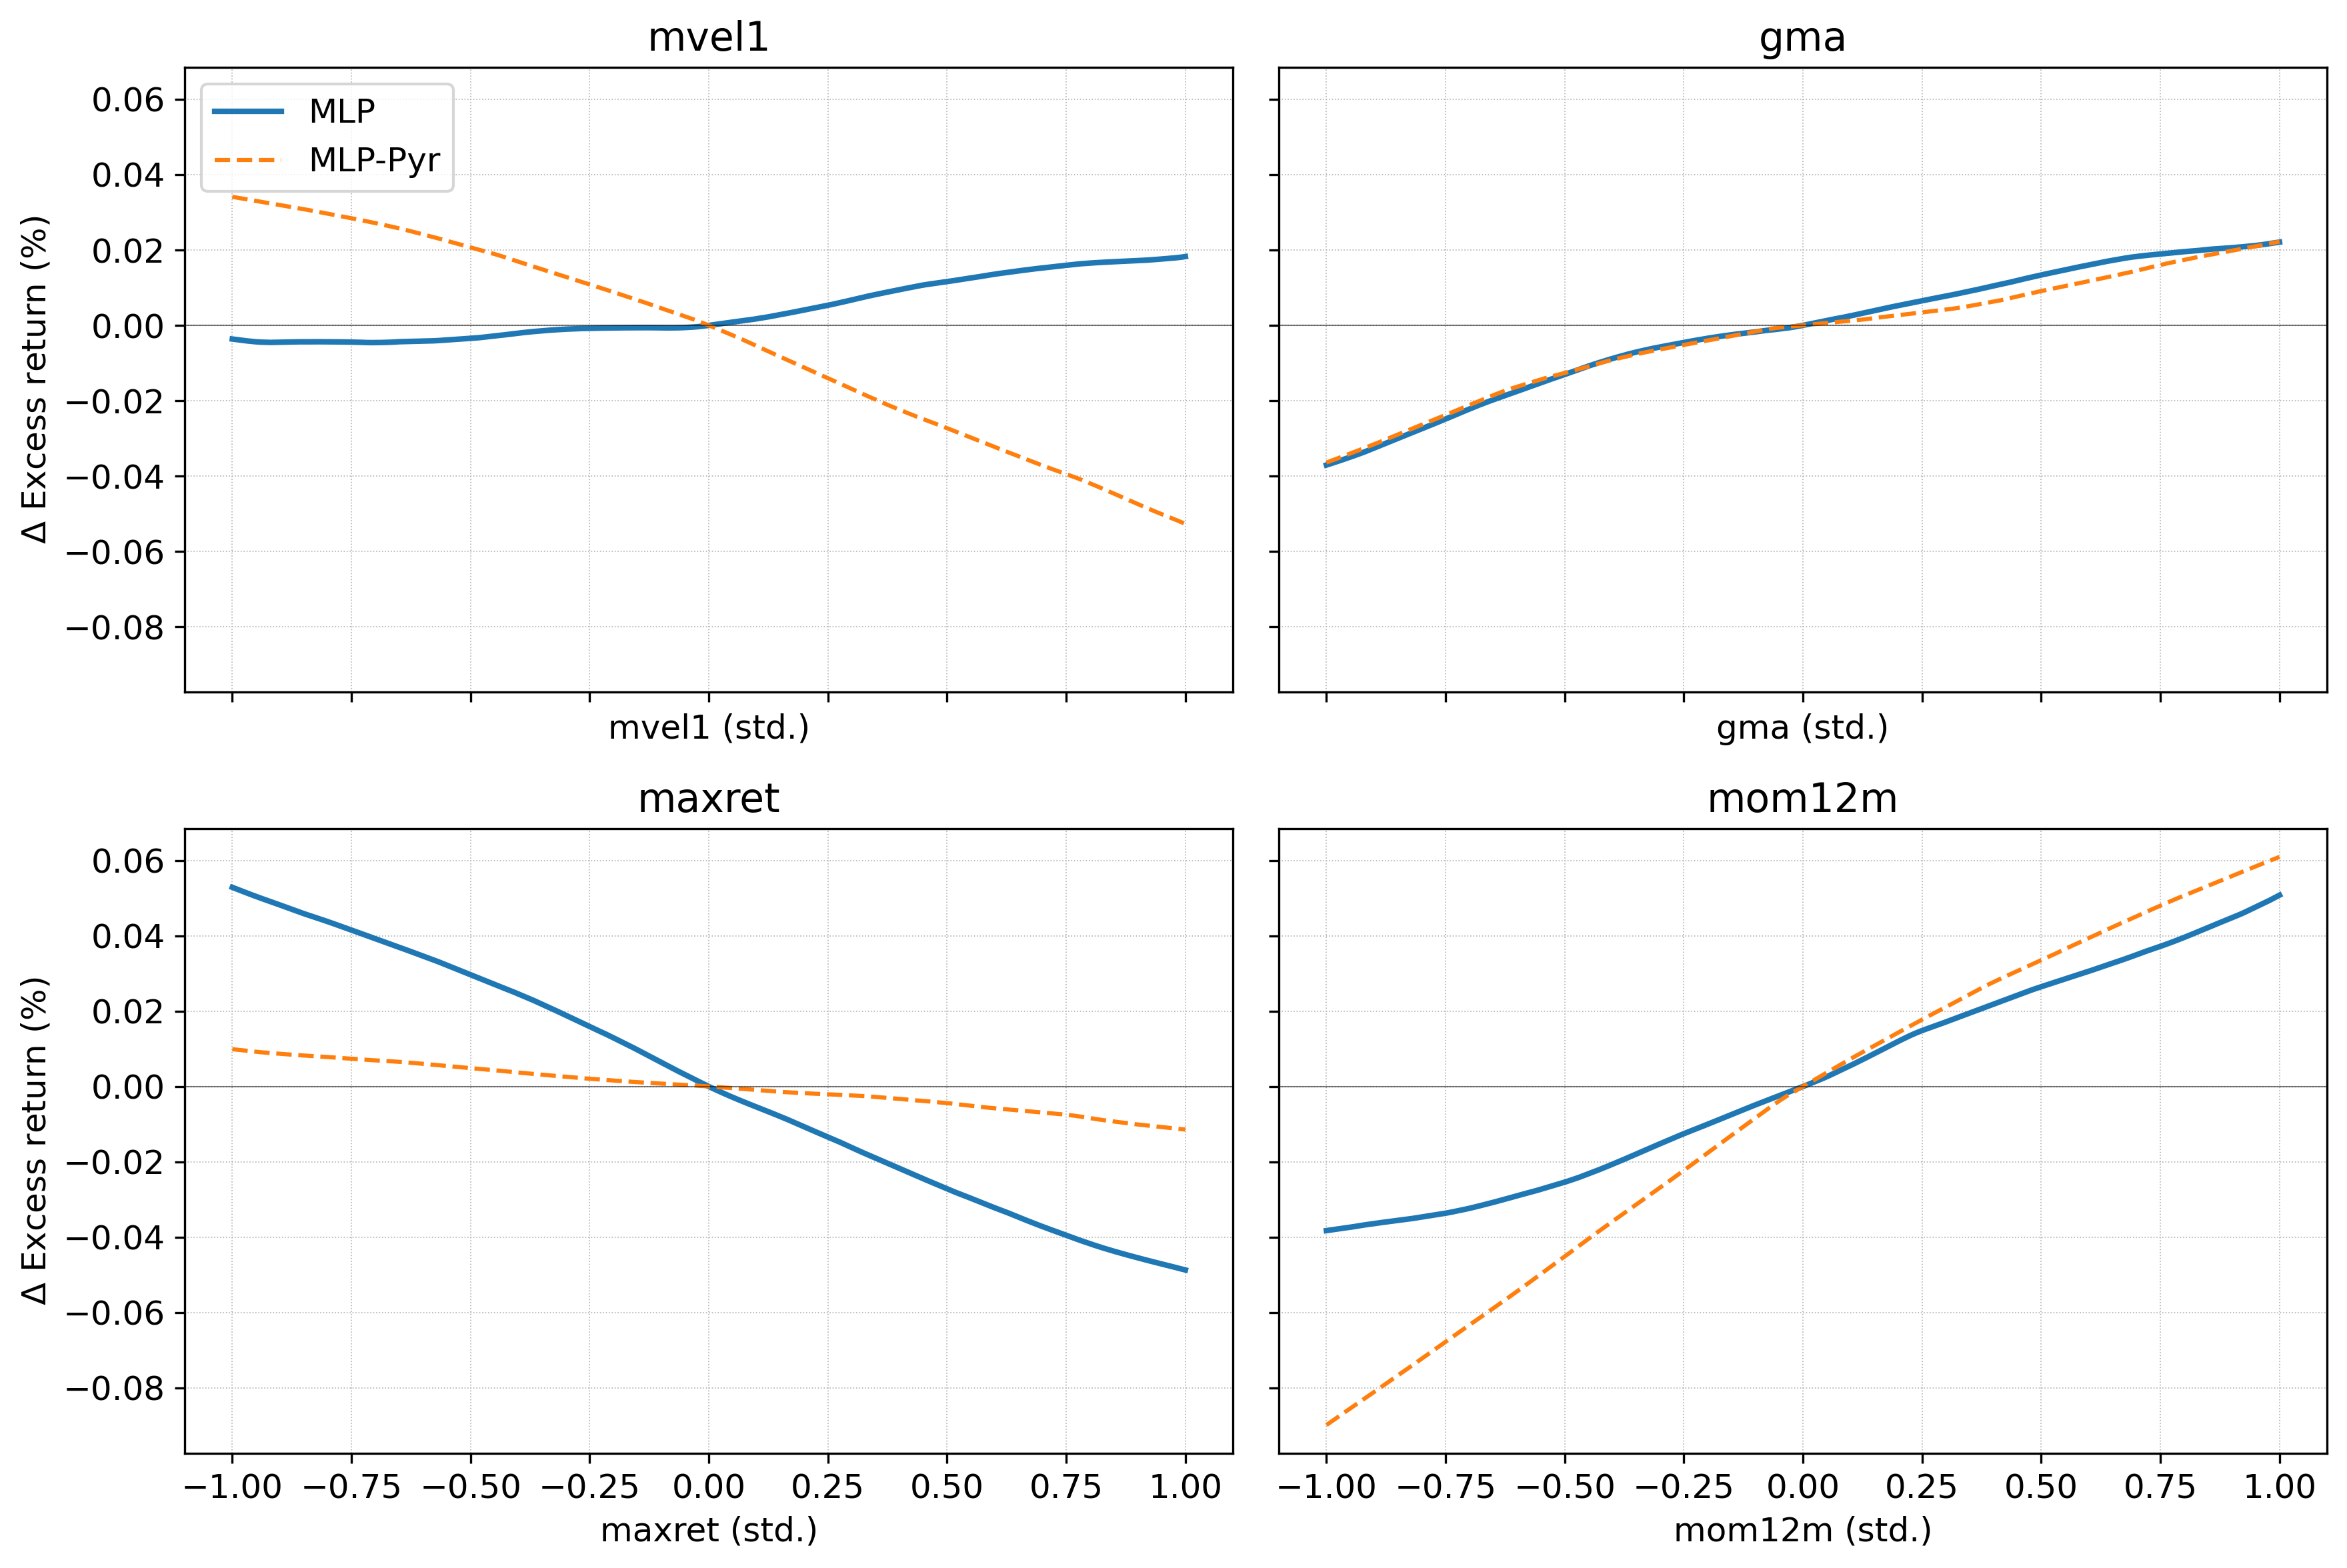

In [27]:
# plot
# use a +- 1 std grid
grid = np.linspace(-1, 1, 200)

features_to_plot = ['mvel1','gma','maxret','mom12m']
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharey=True)
axes = axes.flatten()

for i, (ax, feat) in enumerate(zip(axes, features_to_plot)):
    j = feature_cols.index(feat)

    # MLP
    c_mlp = ensemble_pytorch_curve(best_models, j, grid, device)
    ax.plot(grid, c_mlp,      label='MLP',   lw=2)

    # MLP-Pyr
    c_pyr = ensemble_pytorch_curve(best_models_pyr, j, grid, device)
    ax.plot(grid, c_pyr,      label='MLP-Pyr', ls='--')

    ax.axhline(0, color='k', lw=0.5, alpha=0.5)
    ax.set_title(feat)
    ax.set_xlabel(f"{feat} (std.)")
    ax.grid(True, ls=':', lw=0.4)
    if i < 2:
        ax.tick_params(axis='x', labelbottom=False)

axes[0].set_ylabel("$\Delta$ Excess return (%)")
axes[2].set_ylabel("$\Delta$ Excess return (%)")
axes[0].legend(loc='upper left', fontsize=12)
plt.tight_layout()
plt.savefig('figs/feature_curves.png', bbox_inches='tight')
plt.show()


In [48]:
# generate feature curves for all features
grid           = np.linspace(-1, 1, 200)   # ±1 σ grid
n_cols, n_rows = 4, 6
per_fig        = n_cols * n_rows           # 15 panels per page


# drop interactions ("_x_") and NACE dummies
plot_features = [
    f for f in feature_cols
    if "_x_" not in f and not f.startswith("NACE_")
]

# pre-compute mapping from feature name → column index
fidx = {f: i for i, f in enumerate(feature_cols)}


# page loop
for page, start in enumerate(range(0, len(plot_features), per_fig), 1):
    feats = plot_features[start : start + per_fig]

    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(n_cols * 4, n_rows * 3),
        sharey=True
    )
    axes = axes.flatten()
    for ax in axes:
        ax.set_visible(False)

    for k, feat in enumerate(feats):
        ax = axes[k]
        ax.set_visible(True)
        j  = fidx[feat]

        # compute marginal‐effect curves
        c_mlp = ensemble_pytorch_curve(best_models,     j, grid, device)
        c_pyr = ensemble_pytorch_curve(best_models_pyr, j, grid, device)

        ax.plot(grid, c_mlp,      lw=1.5, label="MLP")
        ax.plot(grid, c_pyr, ls="--", lw=1.0, label="MLP-pyr")
        ax.axhline(0, color="k", lw=0.5, alpha=0.4)

        ax.set_title(feat,             fontsize=8)
        ax.set_xlabel(f"{feat} (std.)", fontsize=7)
        ax.grid(True, ls=":", lw=0.3)

        # only bottom row shows x-tick labels
        if k // n_cols != n_rows - 1:
            ax.tick_params(axis="x", labelbottom=False)
        # only first column shows y-label
        if k % n_cols == 0:
            ax.set_ylabel(r"$\Delta$ Excess return (%)", fontsize=7)

    axes[0].legend(fontsize=8, loc="upper left")
    plt.tight_layout()

    outfile = f"figs/feature_curves_page{page:02d}.png"
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    # plt.show()
    plt.close(fig)


In [35]:
# set up the ensemble
cross_feat = 'mvel1'

j_cross_feat  = feature_cols.index(cross_feat)

# plot panels
features_to_plot = ['idiovol','gma','maxret', 'mom12m']
grid     = np.linspace(-1, 1, 200)       # your rank-normalised range
fixed_ls = [-1, -0.5, 0, 0.5, 1]         # curves for these mvel1-values
colors   = plt.cm.viridis(np.linspace(0,1,len(fixed_ls)))

In [36]:
years    = ['21','22','23','24']
runs     = list(range(n_runs))         # e.g. [0,1,2,3,4]
mlp_runs = [(y,r) for y in years for r in runs]
P        = len(feature_cols)

# precompute the raw-return baseline at X=0 for every (year,run)
baseline = {}
zero_X   = torch.zeros((1,P), dtype=torch.float32, device=device)
for y, r in mlp_runs:
    m = best_models[(y,r)]
    m.eval()
    with torch.no_grad():
        z0 = m(zero_X).item()                    # in z-space
    # invert and scale to percent
    raw0 = y_scalers[y].inverse_transform([[z0]]).flatten()[0] * 100
    baseline[(y,r)] = raw0

def ensemble_interaction_curve(j_feat, j_cross_feat, fixed_mvel1, grid, mlpruns, best_models):
    """
    j_feat       : index of the swept-out feature (mom1m, mom12m, etc.)
    fixed_mvel1  : one of [-1, -0.5, 0, 0.5, 1]
    grid         : array of std-scaled values for that feature
    """
    G = len(grid)
    Xg = np.zeros((G, P), dtype=np.float32)
    Xg[:, j_cross_feat] = fixed_mvel1
    Xg[:, j_feat]  = grid
    Xt = torch.tensor(Xg, dtype=torch.float32, device=device)

    all_preds = []
    for y, r in mlpruns:
        m = best_models[(y, r)]
        m.eval()
        with torch.no_grad():
            zhat = m(Xt).cpu().numpy().flatten()    # (G,) in z-space

        # invert to raw % returns
        raw = (y_scalers[y]
               .inverse_transform(zhat.reshape(-1,1))
               .flatten()) * 100

        # center by the precomputed baseline
        all_preds.append(raw - baseline[(y,r)])

    return np.stack(all_preds, axis=0).mean(axis=0)  # avg over (year,run)

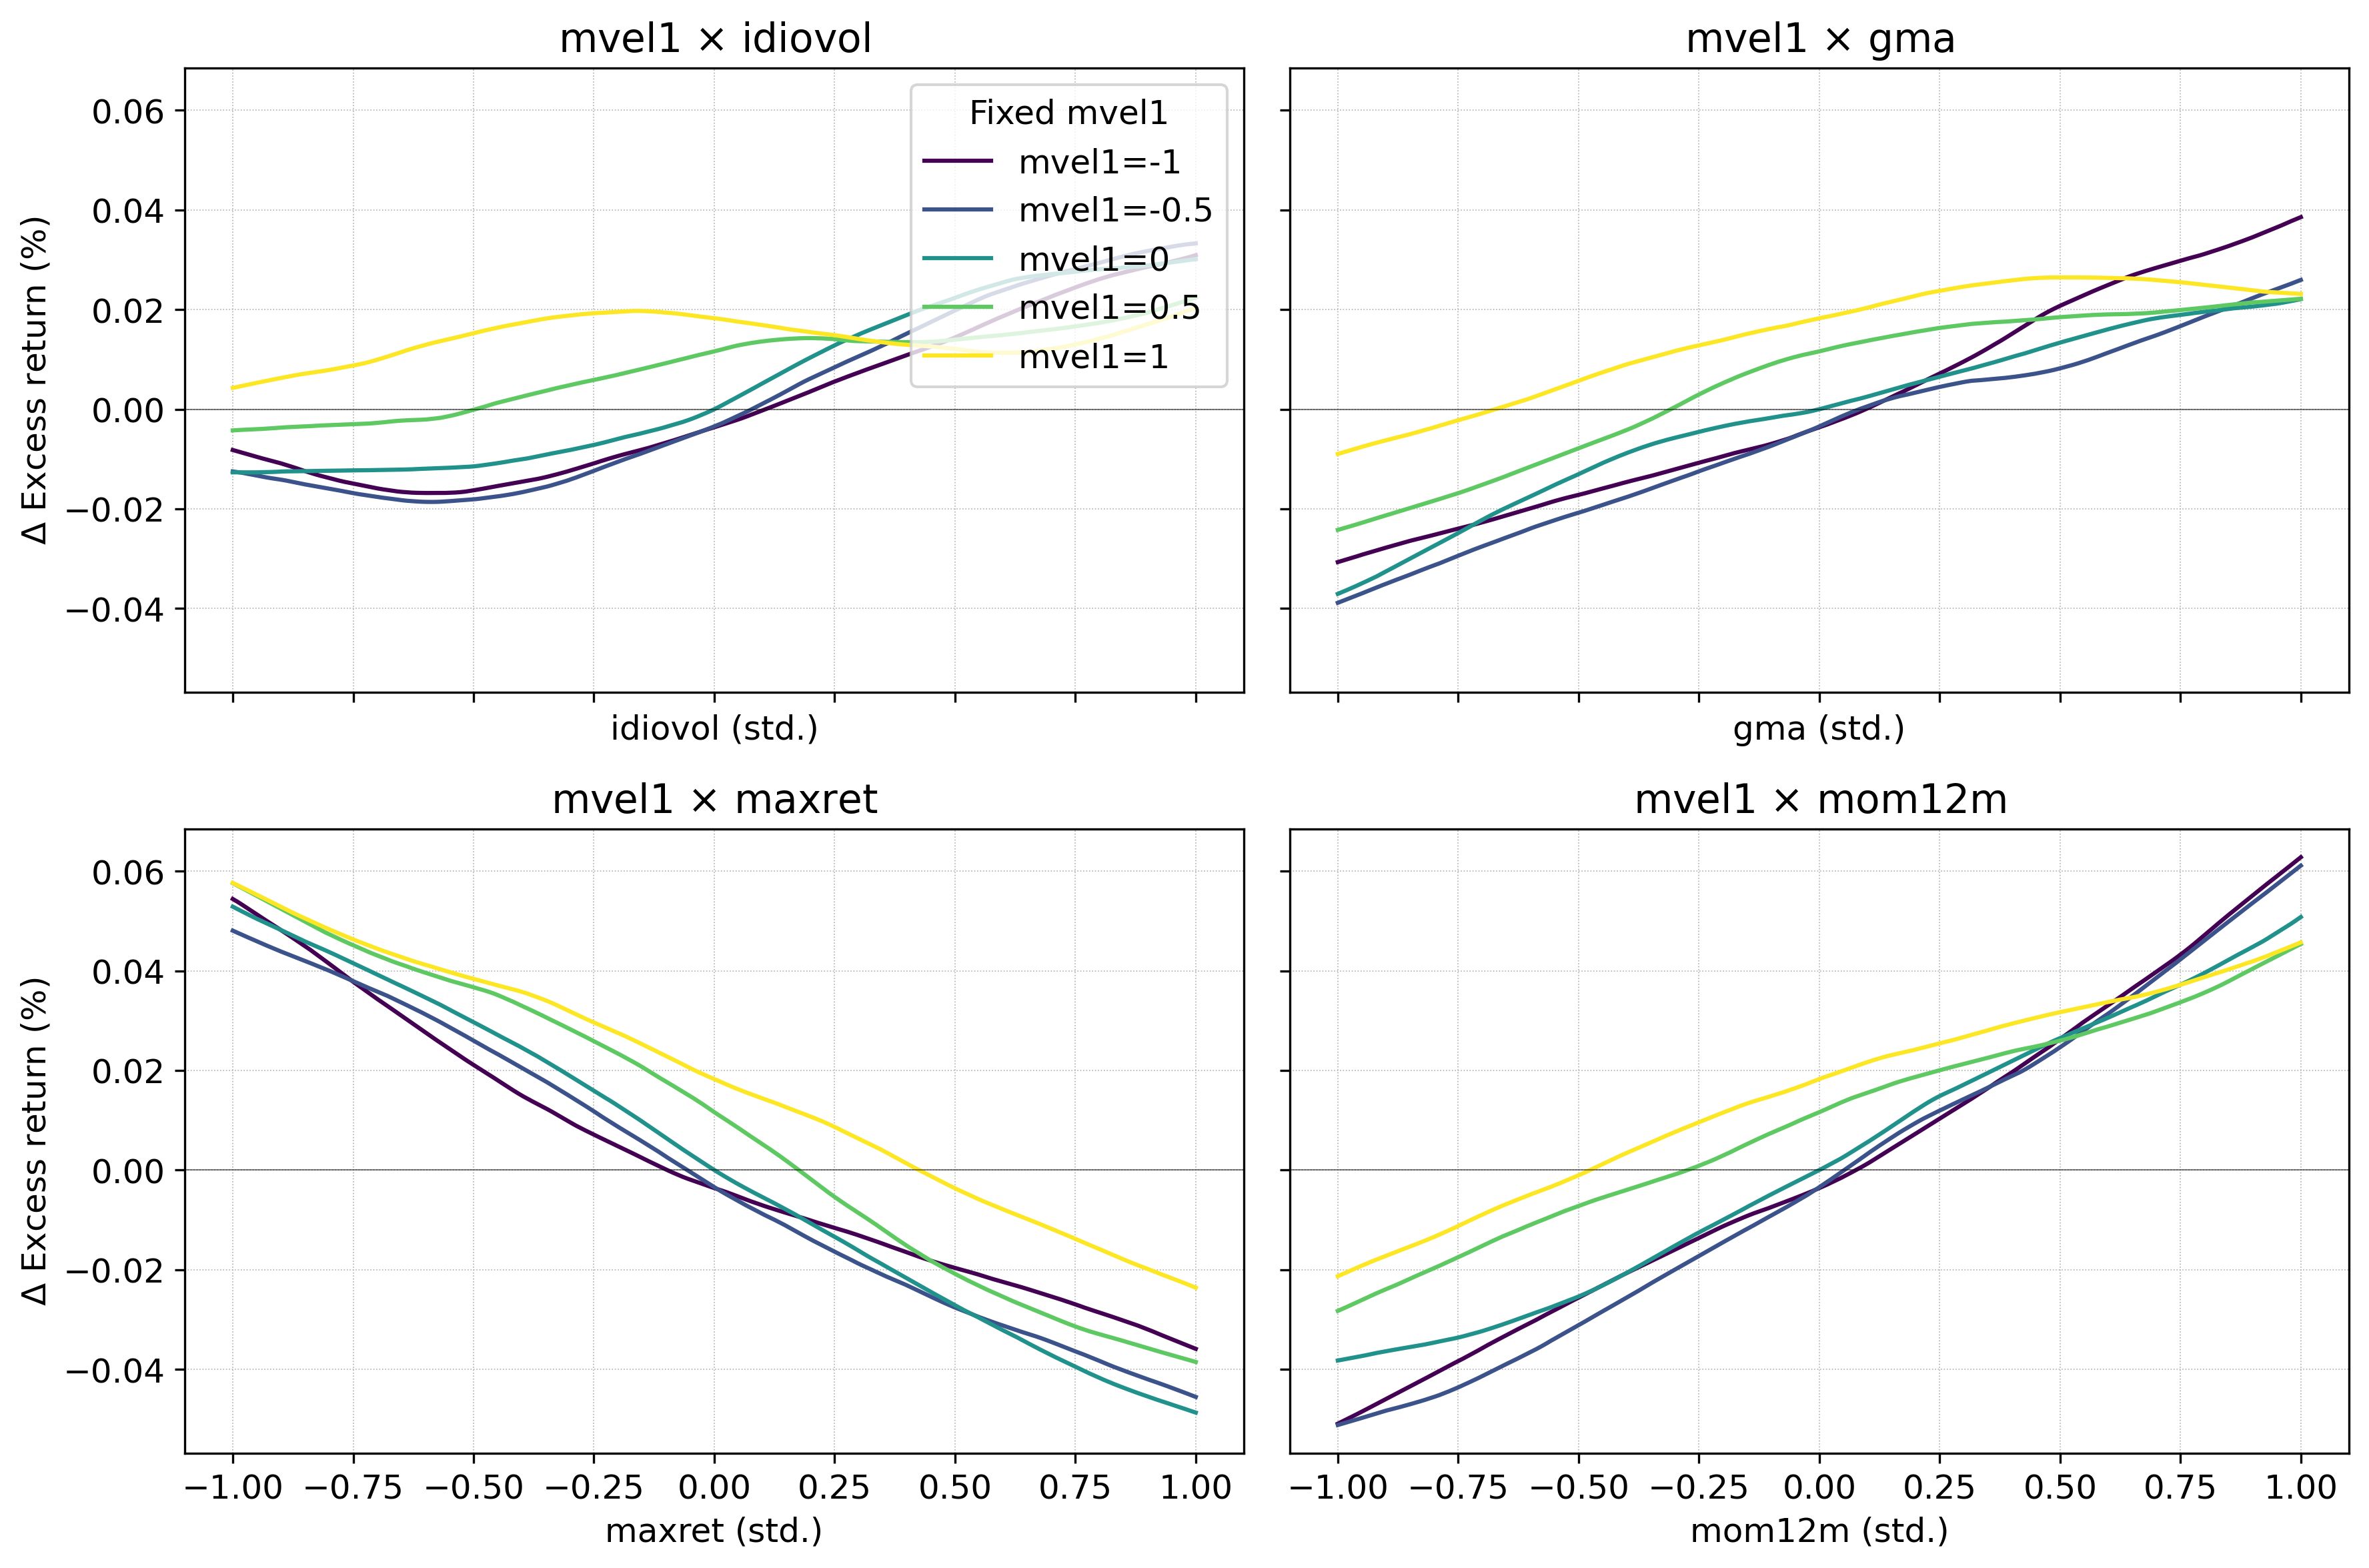

In [37]:
fig, axes = plt.subplots(2, 2, figsize=(12,8), sharey=True)
axes = axes.flatten()

for i, (ax, feat) in enumerate(zip(axes, features_to_plot)):
    j_feat = feature_cols.index(feat)

    for v, color in zip(fixed_ls, colors):
        curve = ensemble_interaction_curve(j_feat, j_cross_feat, v, grid, mlp_runs, best_models)
        ax.plot(grid, curve, label=f"{cross_feat}={v}", color=color)

    ax.axhline(0, color='k', lw=0.5, alpha=0.5)
    ax.set_title(f"{cross_feat} $\\times$ {feat}")
    ax.set_xlabel(f"{feat} (std.)")
    ax.grid(True, ls=':', lw=0.4)
    if i < 2:
        ax.tick_params(axis='x', labelbottom=False)

axes[0].set_ylabel("$\Delta$ Excess return (%)")
axes[2].set_ylabel("$\Delta$ Excess return (%)")
axes[0].legend(title=f"Fixed {cross_feat}", fontsize=12, loc='upper right')

plt.tight_layout()
plt.savefig('figs/interaction_curves.png', bbox_inches='tight')
plt.show()
plt.close(fig)


In [38]:
years    = ['21','22','23','24']
runs     = list(range(n_runs))       
pyr_runs = [(y,r) for y in years for r in runs]

# precompute the raw-return baseline at X=0 for every (year,run)
baseline = {}
zero_X   = torch.zeros((1,P), dtype=torch.float32, device=device)
for y, r in pyr_runs:
    m = best_models_pyr[(y,r)]
    m.eval()
    with torch.no_grad():
        z0 = m(zero_X).item()                    # in z-space
    # invert and scale to percent
    raw0 = y_scalers[y].inverse_transform([[z0]]).flatten()[0] * 100
    baseline[(y,r)] = raw0

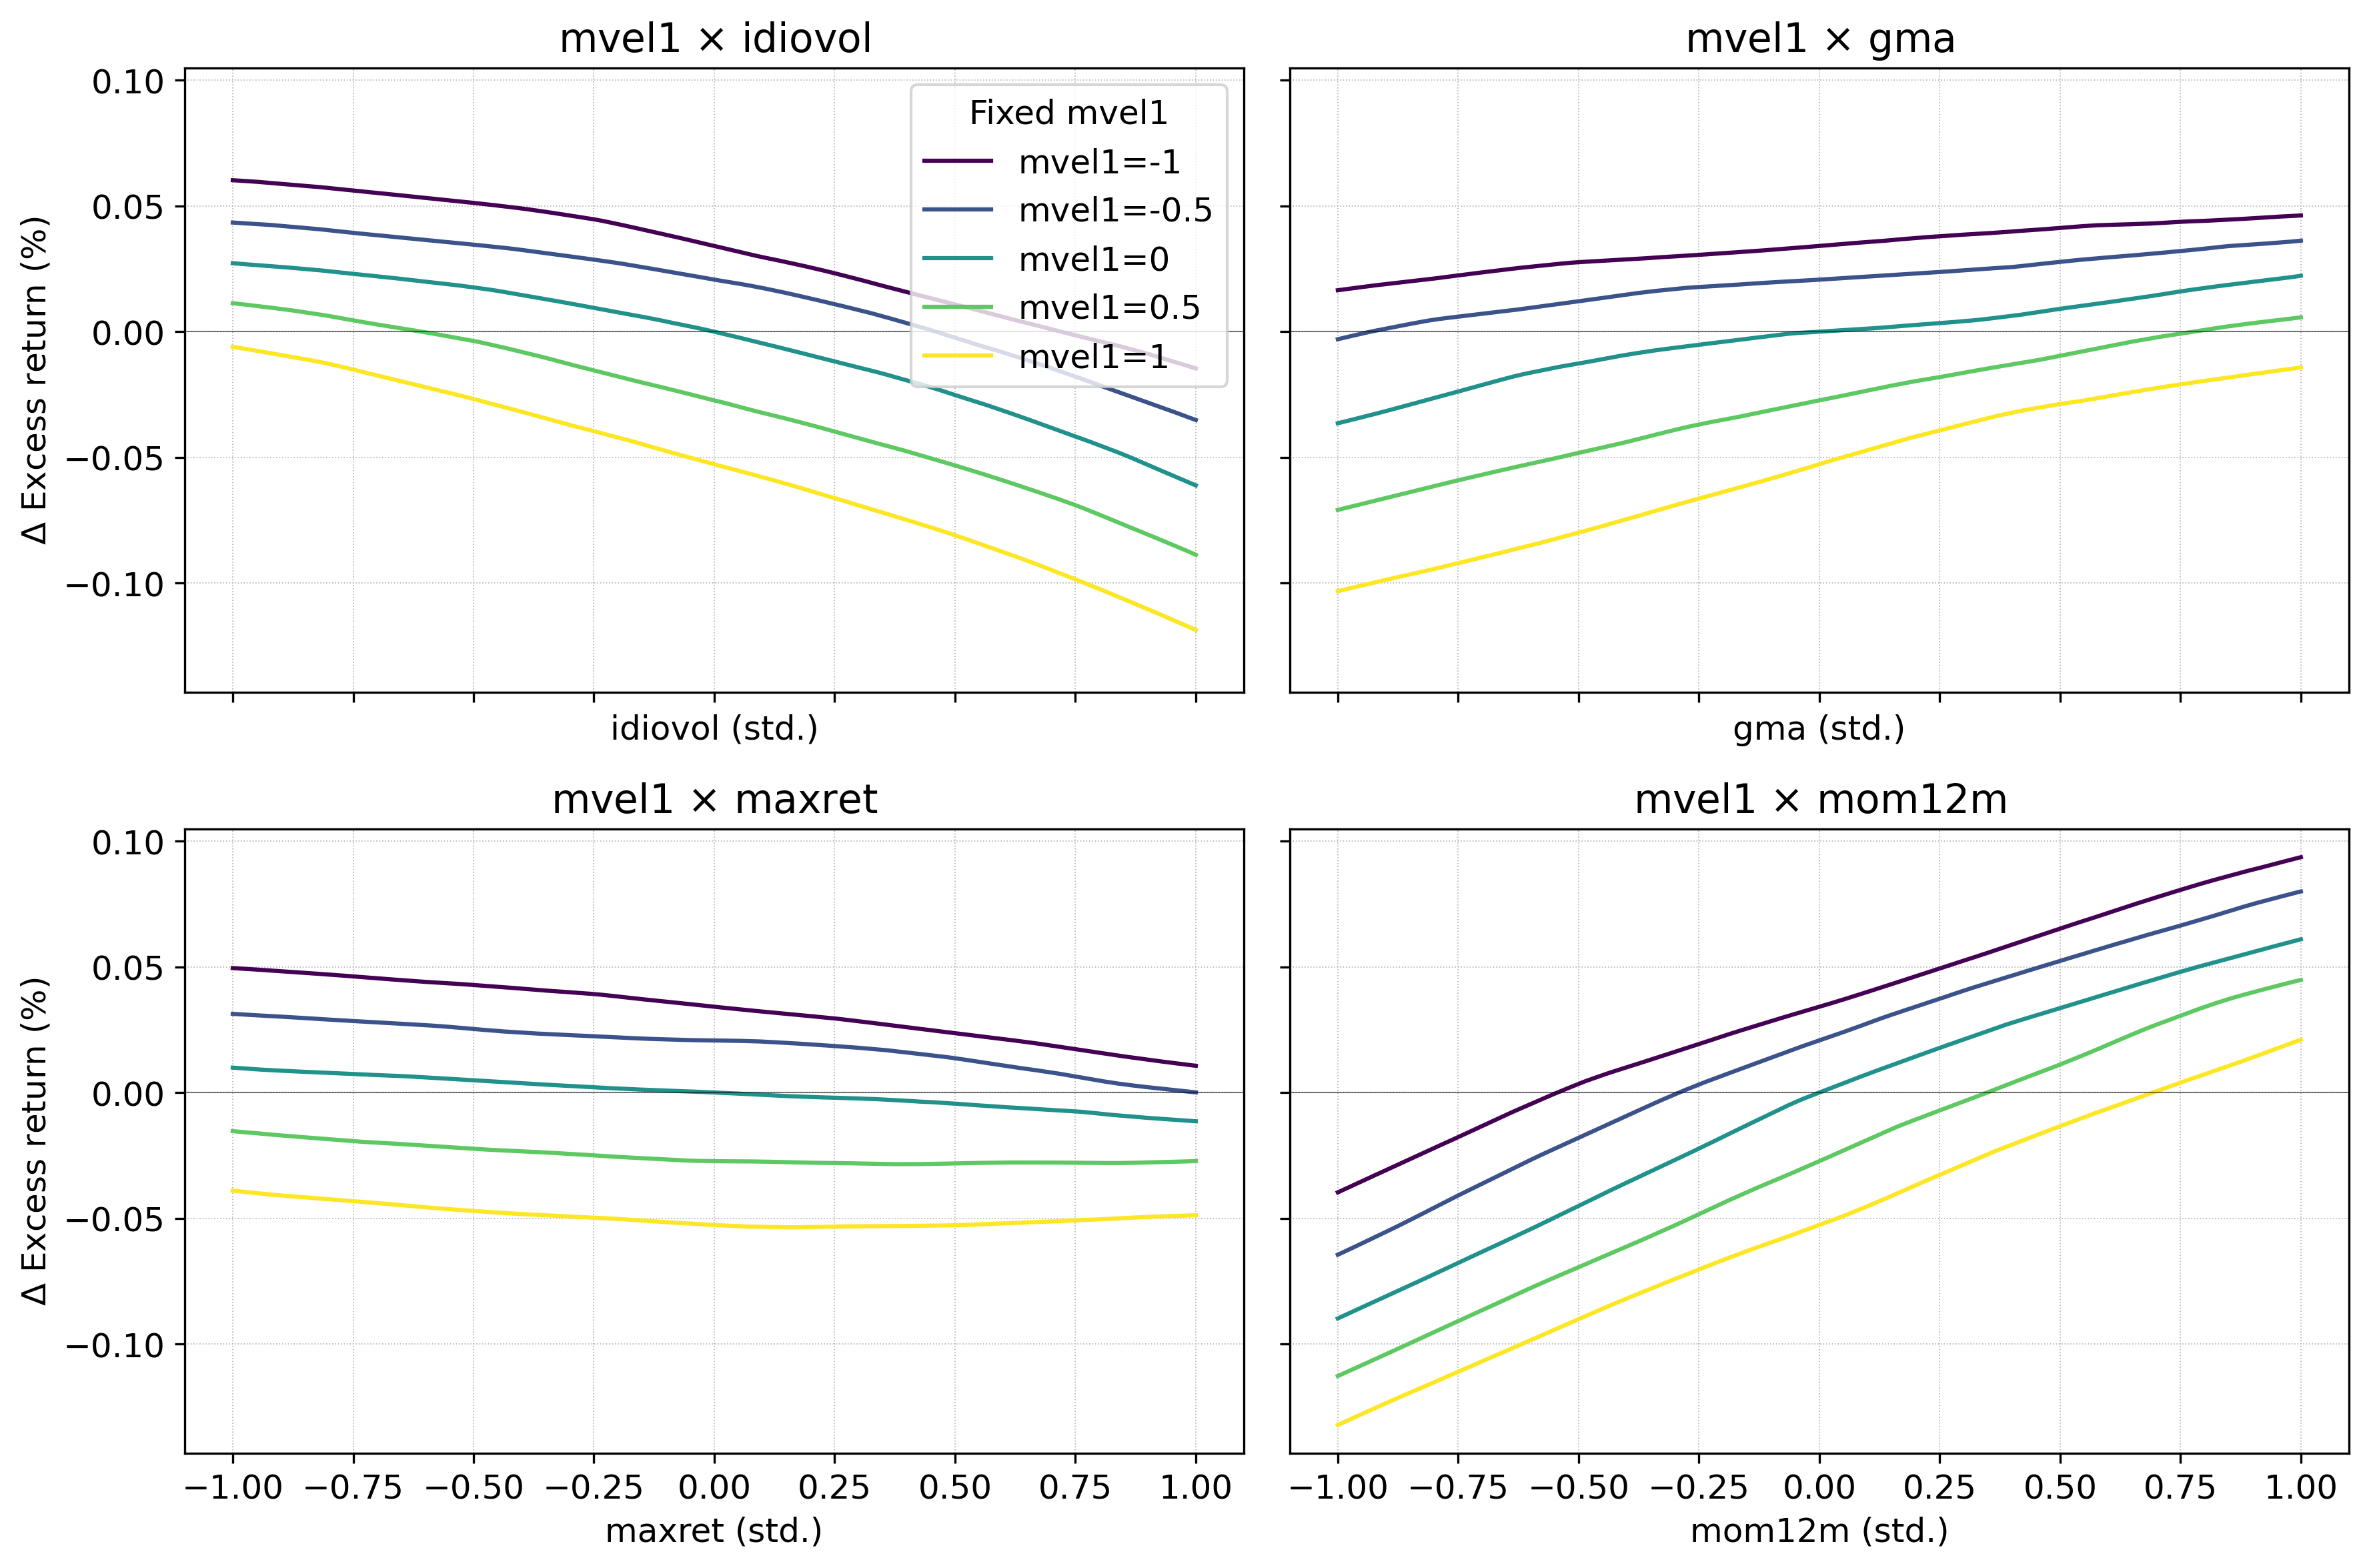

In [39]:
fig, axes = plt.subplots(2, 2, figsize=(12,8), sharey=True)
axes = axes.flatten()

for i, (ax, feat) in enumerate(zip(axes, features_to_plot)):
    j_feat = feature_cols.index(feat)

    for v, color in zip(fixed_ls, colors):
        curve = ensemble_interaction_curve(j_feat, j_cross_feat, v, grid, pyr_runs, best_models_pyr)
        ax.plot(grid, curve, label=f"{cross_feat}={v}", color=color)

    ax.axhline(0, color='k', lw=0.5, alpha=0.5)
    ax.set_title(f"{cross_feat} $\\times$ {feat}")
    ax.set_xlabel(f"{feat} (std.)")
    ax.grid(True, ls=':', lw=0.4)
    if i < 2:
        ax.tick_params(axis='x', labelbottom=False)

axes[0].set_ylabel("$\Delta$ Excess return (%)")
axes[2].set_ylabel("$\Delta$ Excess return (%)")
axes[0].legend(title=f"Fixed {cross_feat}", fontsize=12, loc='upper right')

plt.tight_layout()
plt.savefig('figs/interaction_curves_pyr.png', bbox_inches='tight')
plt.show()
plt.close(fig)
